test

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.colors import LogNorm

In [30]:
df = pd.read_csv(DF_FILE)
# get utterance = 0 for speaker 1, for each digit
df_speaker_1 = df[(df['speaker'] == 1) & (df['utterance'] == 1)]
df_speaker_1.reset_index(drop=True, inplace=True)
df_speaker_1.drop(columns=['Unnamed: 0'], inplace=True)

/var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_62817/3327632892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speaker_1.drop(columns=['Unnamed: 0'], inplace=True)


In [31]:
def plot_digit_gmm(digit_data, digit, n_clusters=3):
    """
    Create visualization of GMM after K-means clustering for a single digit
    Shows MFCC1 vs MFCC2, MFCC1 vs MFCC3, and MFCC2 vs MFCC3
    """
    # Create figure with 3 subplots for this digit
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'GMM Contours with K-means Clusters for Digit {digit} (MFCCs 1-3)', fontsize=14)
    
    mfcc_pairs = [(0, 1), (0, 2), (1, 2)]  # Pairs of MFCCs to plot
    
    # Extract MFCCs 1, 2, and 3 (columns 5, 6, and 7)
    X = digit_data.iloc[:, 5:8].values
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Fit GMM using the K-means clusters as initialization
    gmm = GaussianMixture(
        n_components=n_clusters,
        random_state=42,
        means_init=kmeans.cluster_centers_
    )
    gmm.fit(X_scaled)
    
    # Plot for each MFCC pair
    for idx, ((i, j), ax) in enumerate(zip(mfcc_pairs, axes)):
        # Extract the two MFCCs we want to plot
        X_pair = X_scaled[:, [i, j]]
        
        # Create mesh grid for contour plot
        x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
        y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                           np.linspace(y_min, y_max, 100))
        
        # Fit 2D GMM for visualization
        gmm_2d = GaussianMixture(
            n_components=n_clusters,
            random_state=42
        )
        gmm_2d.fit(X_pair)
        
        # Evaluate GMM on grid
        pos = np.dstack((xx.ravel(), yy.ravel()))[0]
        Z = np.exp(gmm_2d.score_samples(pos))
        Z = Z.reshape(xx.shape)
        
        # Plot contours and scatter points
        ax.contourf(xx, yy, Z, levels=10, cmap='viridis', alpha=0.5)
        scatter = ax.scatter(X_pair[:, 0], X_pair[:, 1], 
                           c=cluster_labels, cmap='Set1',
                           alpha=0.6, s=30)
        
        # Plot cluster centers
        centers_2d = kmeans.cluster_centers_[:, [i, j]]
        ax.scatter(centers_2d[:, 0], centers_2d[:, 1], 
                  c='red', marker='x', s=200, linewidth=3,
                  label='Cluster Centers')
        
        ax.set_title(f'MFCC{i+1} vs MFCC{j+1}')
        ax.set_xlabel(f'MFCC{i+1}')
        ax.set_ylabel(f'MFCC{j+1}')
        
        if idx == 0:  # Only add legend for first plot
            ax.legend()
    
    plt.tight_layout()
    return fig

In [32]:
def process_and_plot_all_digits(df, n_clusters=3):
    """
    Process data and create plots for all digits
    """
    # Filter for speaker 1 and utterance 1
    df_processed = df[
        (df['speaker'] == 1) & 
        (df['utterance'] == 1)
    ].copy()
    
    # Create plot for each digit
    figs = []
    for digit in range(10):
        digit_data = df_processed[df_processed['digit'] == digit]
        fig = plot_digit_gmm(digit_data, digit, n_clusters)
        figs.append(fig)
    
    return figs

In [33]:
def main(df, n_clusters=3):
    figs = process_and_plot_all_digits(df, n_clusters)
    return figs

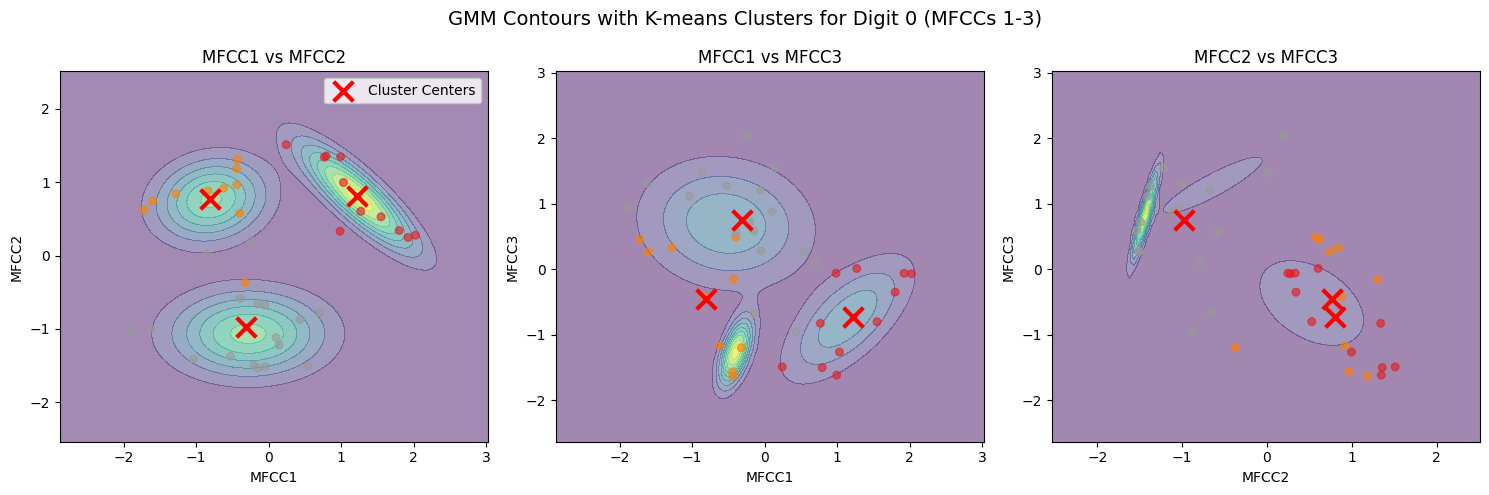

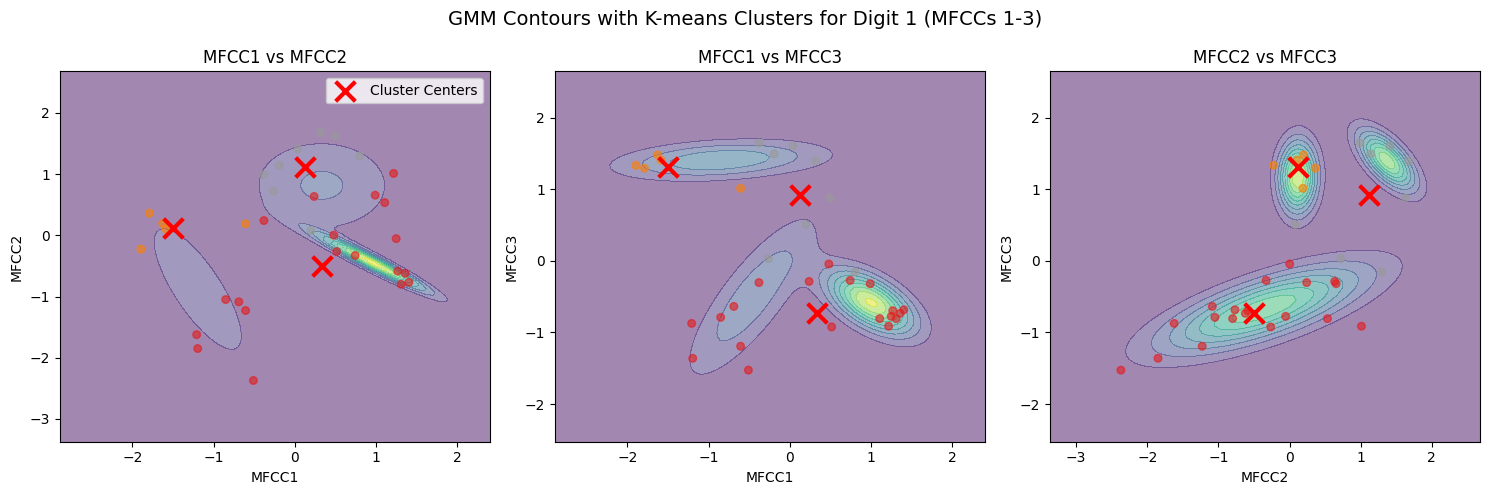

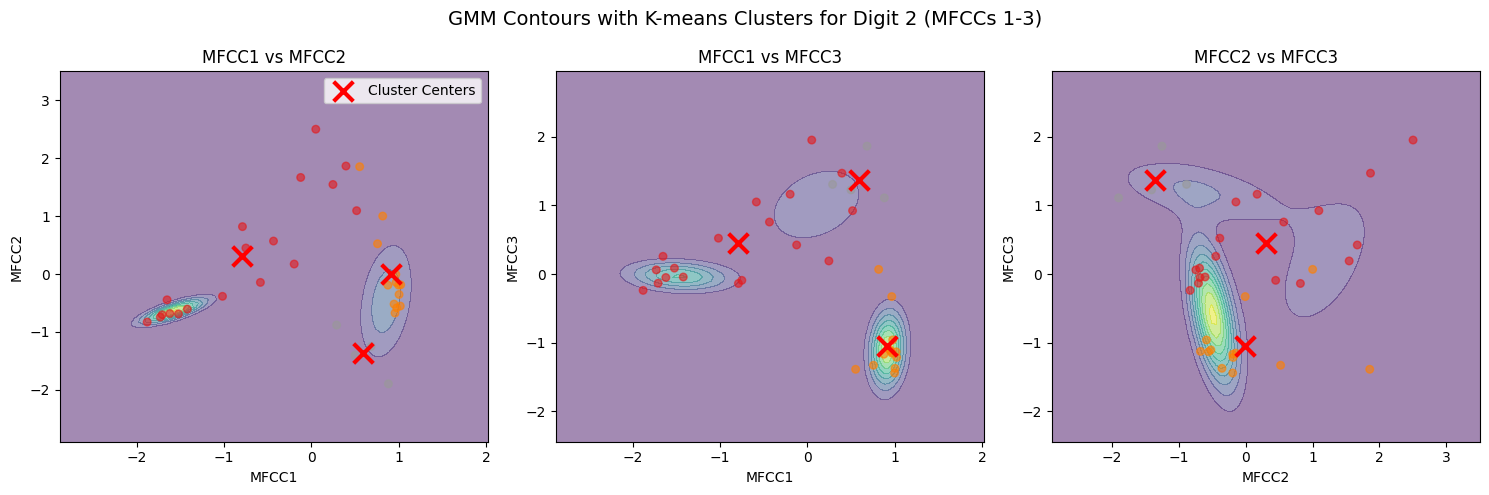

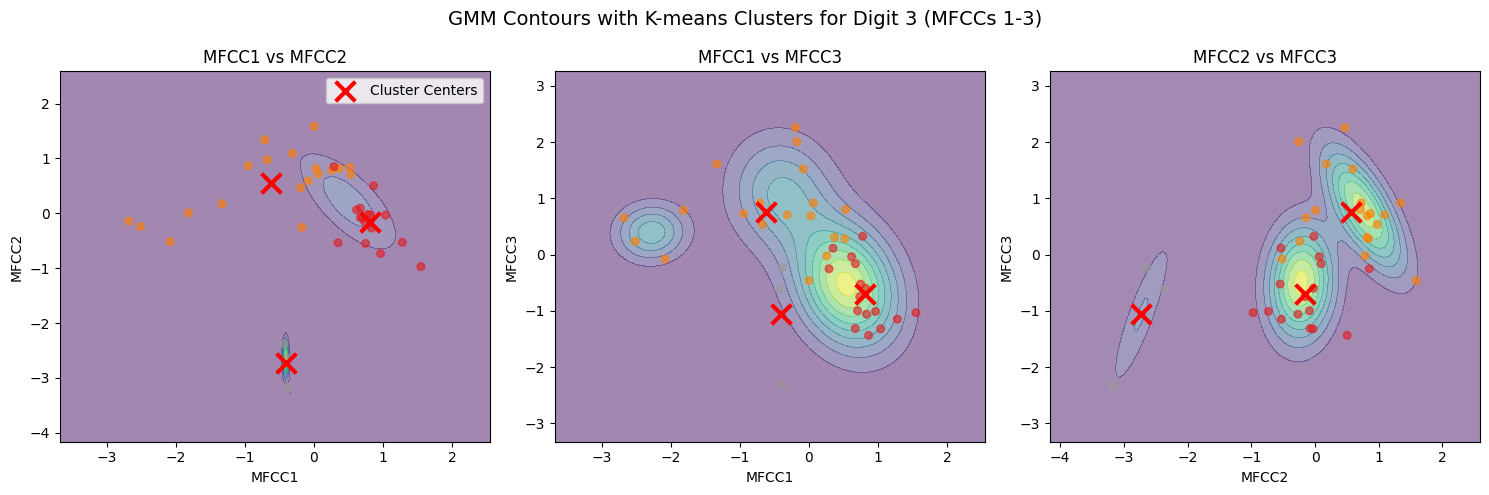

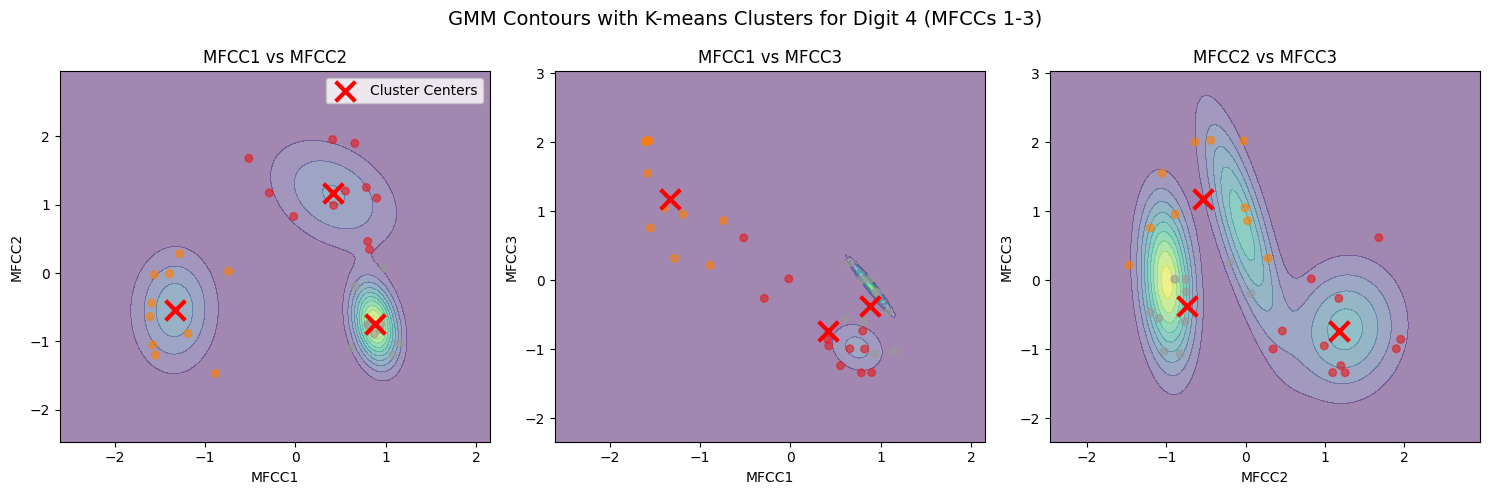

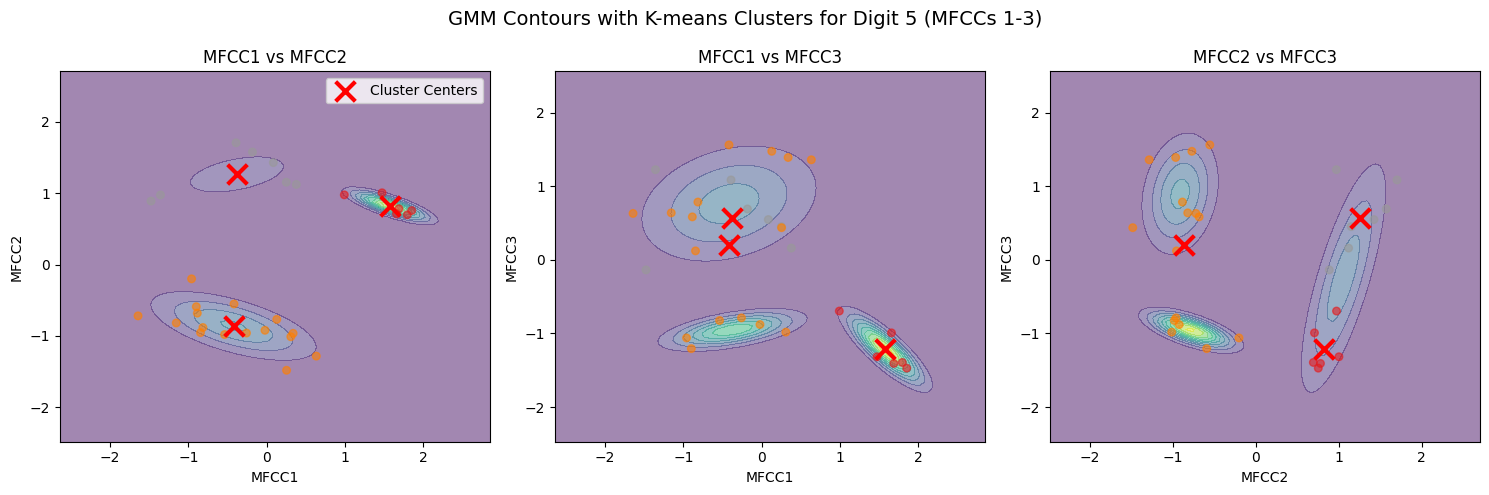

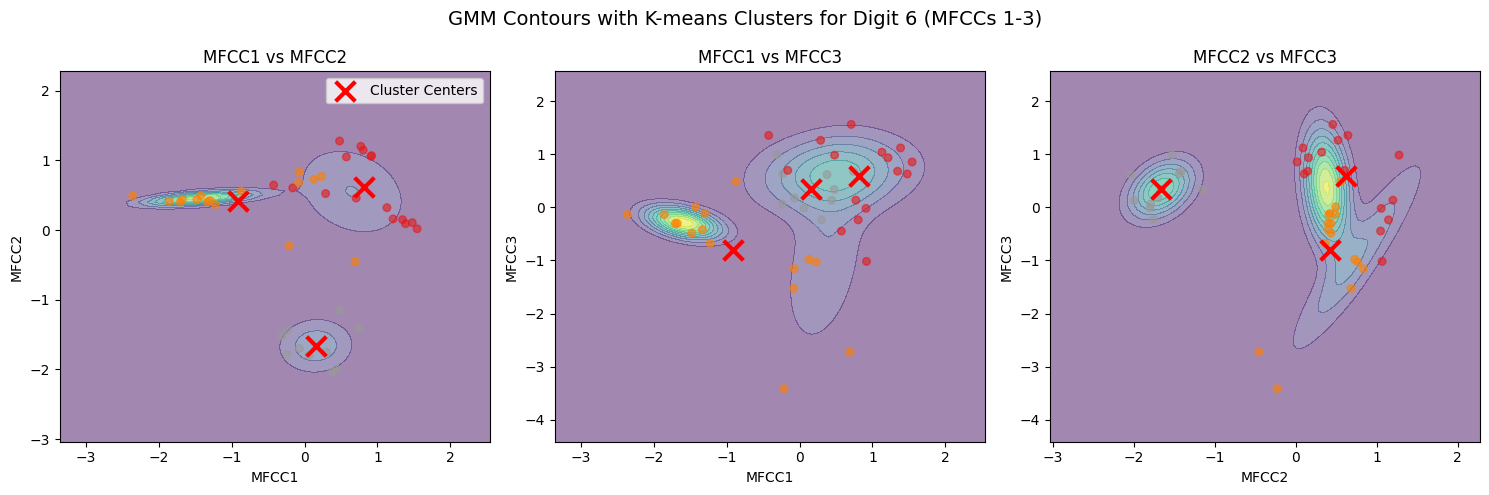

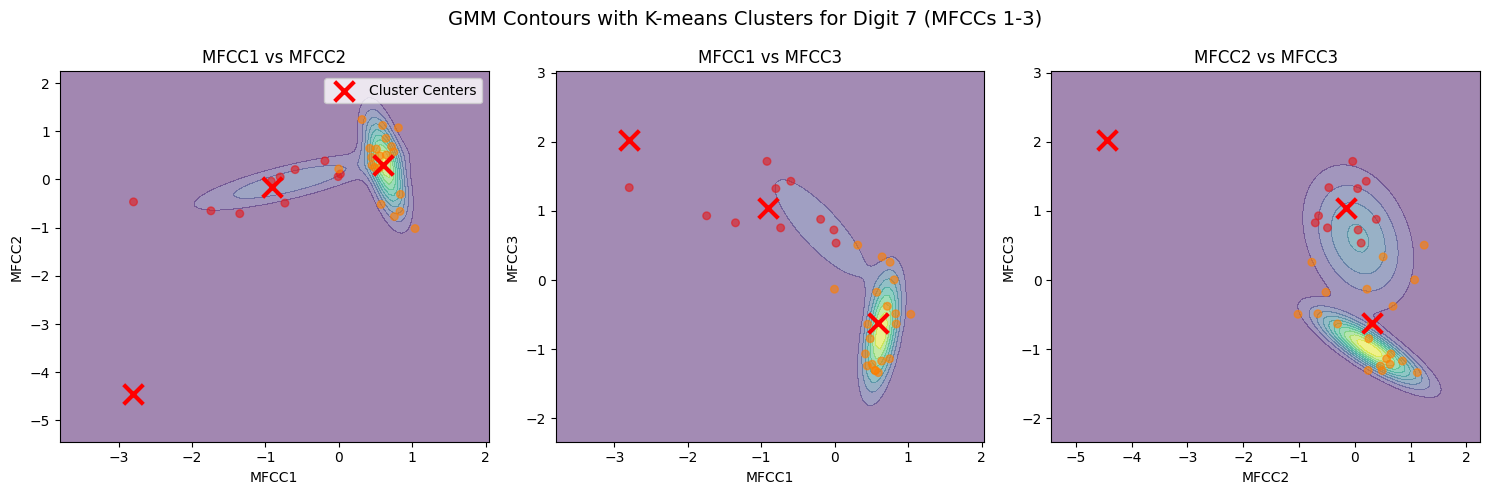

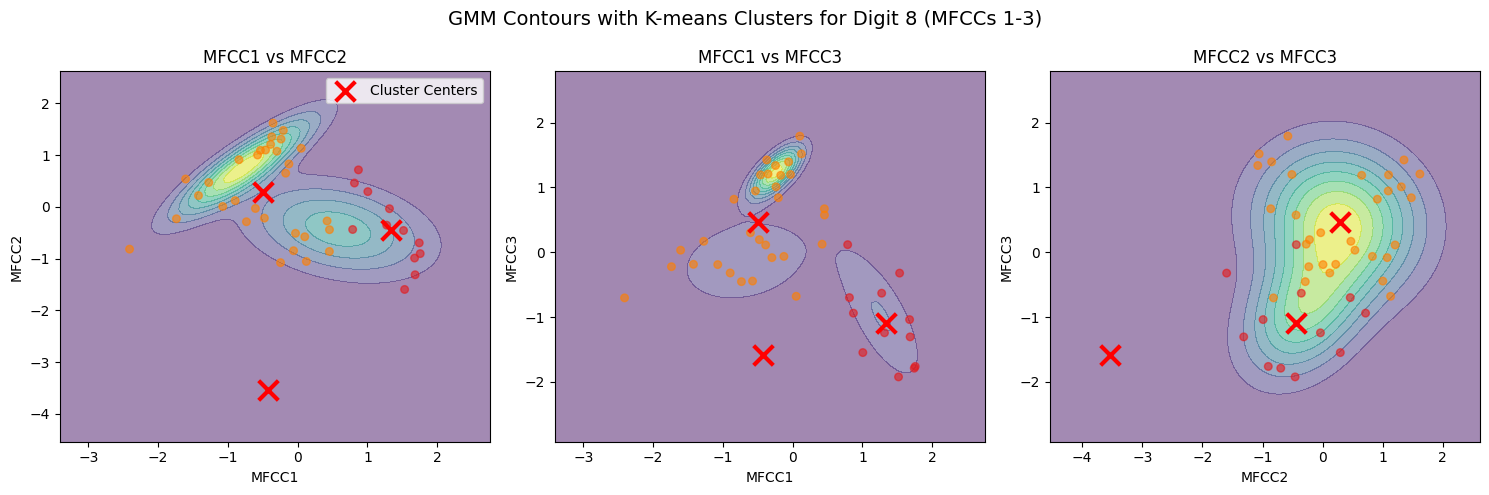

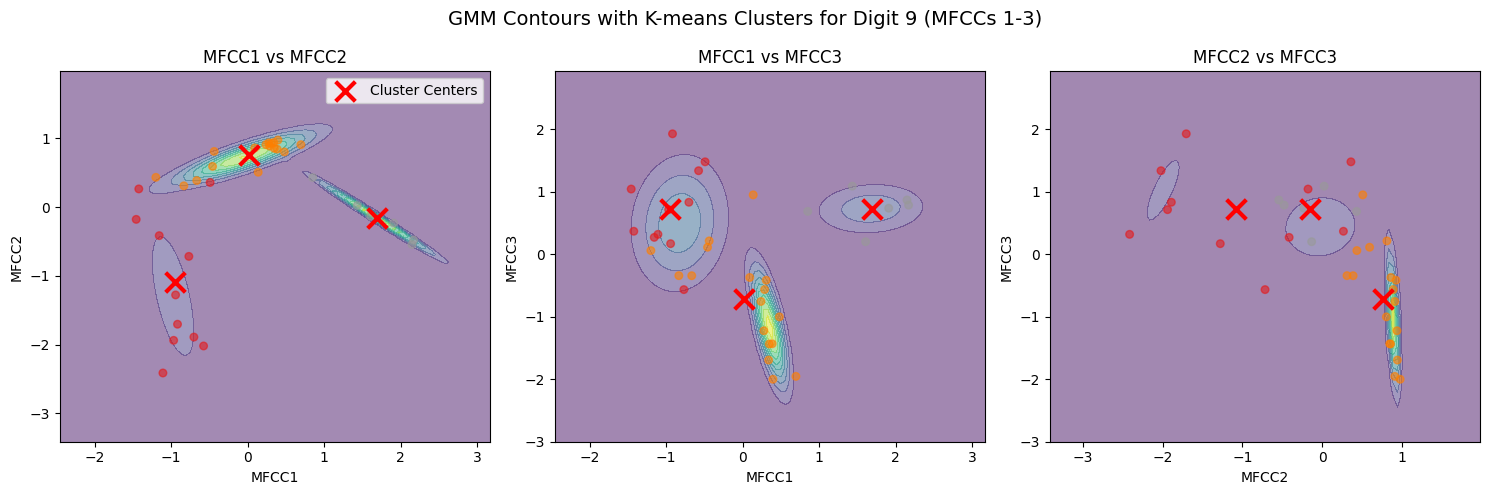

In [34]:
if __name__ == "__main__":
    # Assuming df is your input dataframe
    figs = main(df_speaker_1)
    plt.show()